In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.utils import to_categorical
import os
from keras.preprocessing.image import ImageDataGenerator, load_img


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


we have not loaded the last two fully connected layers which act as the classifier.(include_top =False). It should be noted that the last layer has a shape of 7*7*512 of vgg16

In [2]:
from keras.applications import VGG16
vgg_conv =VGG16(weights='imagenet',
               include_top=False, input_shape=(224,224,3))


In [3]:
vgg_conv.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
train_dir ='./clean-dataset/train'
validation_dir ='./clean-dataset/validation'

nTrain =600
nVal =150


In [8]:
# use the ImageDataGenerator class to load the images and flow_from_directory
# to generate batches of images and labels
datagen =ImageDataGenerator(rescale= 1.0/255)
batch_size =20

train_features = np.zeros(shape =(nTrain, 7,7,512))
train_labels =np.zeros(shape =(nTrain, 3))

train_generator =datagen.flow_from_directory(train_dir, target_size=(224,224),
                                            batch_size =batch_size,
                                            class_mode ='categorical',shuffle =True)

i= 0
for inputs_batch, labels_batch in train_generator:
    features_batch =vgg_conv.predict(inputs_batch)
    train_features[i* batch_size: (i+1)* batch_size]= features_batch
    train_labels[i*batch_size: (i+1)*batch_size]= labels_batch
    i+= 1
    if i*batch_size >= nTrain:
        break
        
train_features =np.reshape(train_features, (nTrain, 7*7*512))


Found 600 images belonging to 3 classes.


In [11]:
validation_features =np.zeros(shape =(nVal, 7,7,512))
validation_labels =np.zeros(shape=(nVal, 3))
validation_generator =datagen.flow_from_directory(validation_dir,
                                                 target_size=(224,224),
                                                  batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle= False)
i =0
for inputs_batch ,labels_batch in validation_generator:
    features_batch =vgg_conv.predict(inputs_batch)
    validation_features[i*batch_size: (i+1)*batch_size] =features_batch
    validation_labels[i*batch_size: (i+1)*batch_size] =labels_batch
    i+=1
    if i*batch_size >= nVal:
        break
validation_features =np.reshape(validation_features, (nVal, 7*7*512))

Found 150 images belonging to 3 classes.


In [12]:
from keras import models
from keras import layers
from keras import optimizers

model =models.Sequential()
model.add(layers.Dense(256, activation ='relu', input_dim=7*7*512 ))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer= optimizers.RMSprop(lr =2e-4), 
             loss ='categorical_crossentropy',metrics=['acc'])

history =model.fit(train_features,
                  train_labels, epochs=20, batch_size=batch_size,
                  validation_data=(validation_features, validation_labels))


Train on 600 samples, validate on 150 samples
Epoch 1/20
600/600 [==============================] - 1s 1ms/step - loss: 1.1930 - acc: 0.6017 - val_loss: 0.5640 - val_acc: 0.8067
Epoch 2/20
600/600 [==============================] - 1s 940us/step - loss: 0.4984 - acc: 0.7917 - val_loss: 0.3791 - val_acc: 0.8667
Epoch 3/20
600/600 [==============================] - 1s 942us/step - loss: 0.2484 - acc: 0.9150 - val_loss: 0.3127 - val_acc: 0.9067
Epoch 4/20
600/600 [==============================] - 1s 956us/step - loss: 0.2046 - acc: 0.9300 - val_loss: 0.2938 - val_acc: 0.9067
Epoch 5/20
600/600 [==============================] - 1s 993us/step - loss: 0.1073 - acc: 0.9700 - val_loss: 0.2676 - val_acc: 0.9200
Epoch 6/20
600/600 [==============================] - 1s 1ms/step - loss: 0.0840 - acc: 0.9733 - val_loss: 0.2973 - val_acc: 0.9067
Epoch 7/20
600/600 [==============================] - 1s 957us/step - loss: 0.0799 - acc: 0.9733 - val_loss: 0.2898 - val_acc: 0.9200
Epoch 8/20
600/600 [

In [15]:
fnames =validation_generator.filenames
ground_truth =validation_generator.classes
label2index =validation_generator.class_indices
# in python3, use dict.items() instead of dict.iteritems()
# getting teh mapping from class index to class label
#idx2label =dict((v,k) for k,v in label2index.iteritems())
idx2label =dict((v,k) for k,v in label2index.items())

predictions =model.predict_classes(validation_features)
prob =model.predict(validation_features)
errors =np.where(predictions != ground_truth)[0]
print(" No of errors ={}/{}".format(len(errors), nVal))


 No of errors =14/150


In [32]:
idx2label


array([[3.60770464e-01, 2.56347150e-01, 3.82882386e-01],
       [3.86283286e-02, 9.55541193e-01, 5.83044207e-03],
       [9.97120798e-01, 1.12697526e-05, 2.86793895e-03],
       [9.99952912e-01, 4.44511206e-05, 2.62216440e-06],
       [9.98287380e-01, 9.48200920e-07, 1.71160372e-03],
       [9.99992847e-01, 7.16511613e-06, 1.79847834e-08],
       [9.98683274e-01, 1.21473335e-03, 1.02058446e-04],
       [9.99868512e-01, 6.25701034e-07, 1.30855173e-04],
       [9.99999881e-01, 7.98267834e-08, 1.48342671e-09],
       [9.96231735e-01, 3.47795291e-03, 2.90218828e-04],
       [3.02074086e-02, 9.42838132e-01, 2.69545019e-02],
       [7.08558261e-01, 1.73420772e-01, 1.18020937e-01],
       [3.24551672e-01, 6.33268714e-01, 4.21795920e-02],
       [4.45227791e-03, 9.95374501e-01, 1.73297463e-04],
       [9.99999881e-01, 2.24426859e-08, 1.01495374e-07],
       [9.99844551e-01, 1.52964014e-04, 2.49305117e-06],
       [9.99908566e-01, 9.13618205e-05, 1.16304697e-07],
       [1.00000000e+00, 5.05931

In [23]:
label2index

{'pumpkin': 0, 'tomato': 1, 'watermelon': 2}

In [26]:
len(predictions)

150

In [29]:
np.where(predictions != ground_truth)

(array([  0,   1,  10,  12,  13,  25,  29,  43,  57,  58,  69,  77, 130,
        136]),)

In [30]:
errors

array([  0,   1,  10,  12,  13,  25,  29,  43,  57,  58,  69,  77, 130,
       136])

In [41]:
pred_class.astype('')


dtype('int64')

Original label:pumpkin, Prediction :watermelon, confidence : 0.383


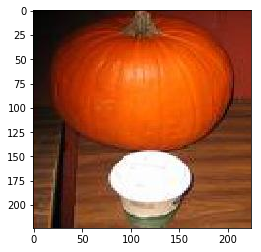

Original label:pumpkin, Prediction :tomato, confidence : 0.956


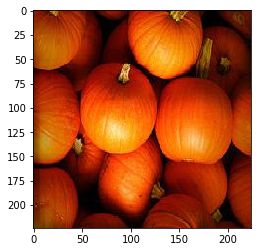

Original label:pumpkin, Prediction :tomato, confidence : 0.943


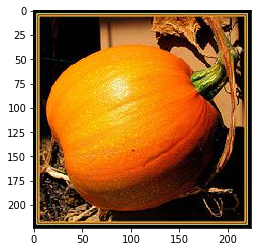

Original label:pumpkin, Prediction :tomato, confidence : 0.633


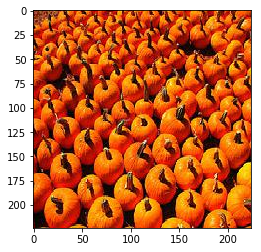

Original label:pumpkin, Prediction :tomato, confidence : 0.995


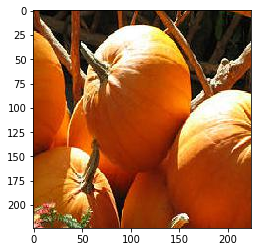

Original label:pumpkin, Prediction :watermelon, confidence : 0.995


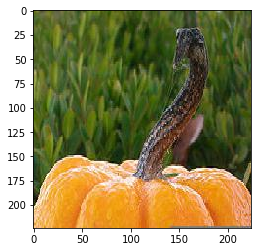

Original label:pumpkin, Prediction :tomato, confidence : 0.657


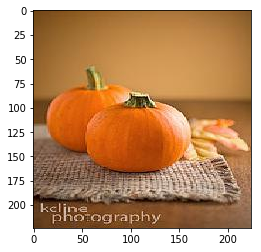

Original label:pumpkin, Prediction :tomato, confidence : 0.936


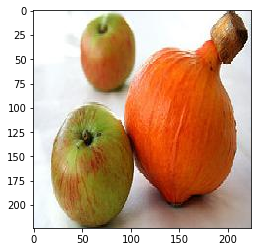

Original label:tomato, Prediction :pumpkin, confidence : 0.998


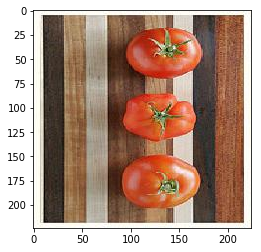

Original label:tomato, Prediction :pumpkin, confidence : 0.931


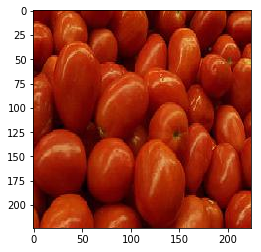

Original label:tomato, Prediction :watermelon, confidence : 1.000


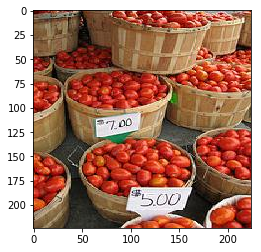

Original label:tomato, Prediction :pumpkin, confidence : 0.812


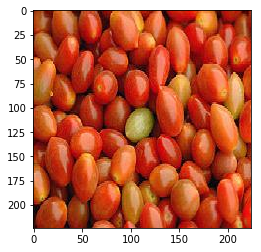

Original label:watermelon, Prediction :pumpkin, confidence : 0.966


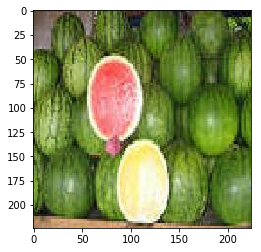

Original label:watermelon, Prediction :pumpkin, confidence : 0.972


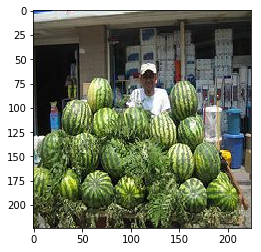

In [42]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    # have a good understanding of '{}'.format, that is a string, can be used not 
    #only in print() function, 
    plt.imshow(original)
    plt.show()